# <div style="color: DarkCyan">Case Study III:MNIST</div>
**Business case:** We want to recognize handwritten digits.

**Data source:** The <a target="_blank" href="http://yann.lecun.com/exdb/mnist/">minist database</a>.

In [1]:
%run utils

In [2]:
import numpy as np
import pandas as pd

## Extract from mldata
Actually sklearn itself provides us with a wide variety of data to run experiments and test methods.

In [3]:
import sklearn.datasets as sklearn_datasets

In [4]:
display_numpy([ds for ds in dir(sklearn_datasets) if not ds.startswith('_')], 'dataset')

,dataset
0,base
1,california_housing
2,clear_data_home
3,covtype
4,dump_svmlight_file
5,fetch_20newsgroups
6,fetch_20newsgroups_vectorized
7,fetch_california_housing
8,fetch_covtype
9,fetch_kddcup99


In [5]:
# Extract data from a data repository
mnist = sklearn_datasets.fetch_mldata('MNIST original', data_home='../data/mnist/')

In [6]:
digit_images = mnist.data
labels = mnist.target

In [7]:
import matplotlib.pyplot as plt
from skimage.io import imshow
import math

# Plot several images at once
def plot_images(images):
    width = int(math.sqrt(len(images[0, :])))
    
    numberOfImages = len(images)
    size = math.ceil(math.sqrt(numberOfImages))

    for i in range(0, numberOfImages):
        plt.subplot(size, size, i + 1)
        plt.axis('off')
        plt.imshow(images[i].reshape(width, width), cmap='gray')
        
def show_images(images):
    plot_images(images)
    plt.show()

## Visualize data
*First view on mnist digits.*

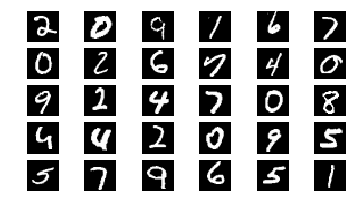

In [8]:
np.random.seed(42)
random_indices = np.random.randint(0, digit_images.shape[0], size=30)

random_digits = digit_images[random_indices, :]

show_images(random_digits)

## Give it a go!


Selecting regularization parameter...
Using hyperparameter=0.5
Evaluating model on 3 folds...



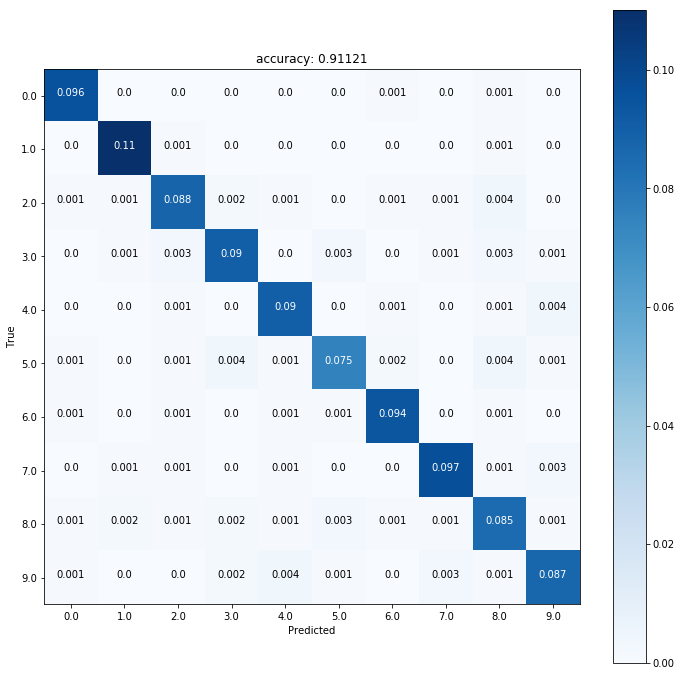

In [9]:
hyperparametrized_model = simple_classification_performance(
    digit_images, 
    labels,  
    n_folds=3,
    grid={'C': [0.5]},
    run_grid_search=False)

## Cross-correlation ("convolution")
*Generate different features from an image.*

In [10]:
from scipy import signal

def apply_crosscorrelation(images, cross_correlation_matrix):
    return np.apply_along_axis(
        lambda image: signal.correlate2d(
            image.reshape([28, 28]), 
            cross_correlation_matrix, boundary='symm', mode='same').flatten(),
        1,
        images)

def show_images_with_cross_correlation(cross_correlation_matrix):
    show_images(apply_crosscorrelation(random_digits, cross_correlation_matrix))

In [11]:
identical = np.array([
    [0,0,0],
    [0,1,0],
    [0,0,0]
])

In [12]:
blurry = 1/16 * np.ones([4, 4])

In [13]:
edge_detection = np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
])

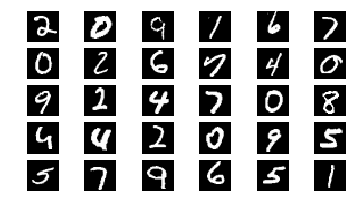

In [14]:
show_images_with_cross_correlation(identical)

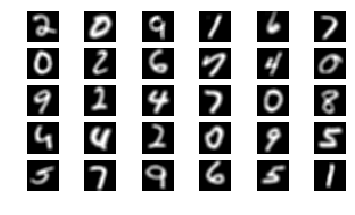

In [15]:
show_images_with_cross_correlation(blurry)

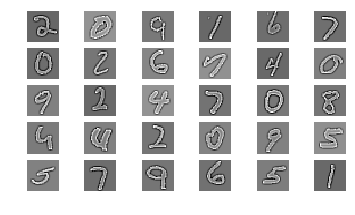

In [16]:
show_images_with_cross_correlation(edge_detection)

## Let's try with correlation features

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class ConvolutionFilterApplier(BaseEstimator, TransformerMixin):
    def __init__(self, *filter_matrices):
        self.filter_matrices = filter_matrices
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.concatenate(
            [X] + [apply_crosscorrelation(X, matrix) for matrix in self.filter_matrices], 
            axis=1)

In [18]:
# Testing with blurry and edge detection
extended_images = ConvolutionFilterApplier(blurry, edge_detection).transform(digit_images)

In [19]:
extended_images.shape

(70000, 2352)


Selecting regularization parameter...
Using hyperparameter=20
Evaluating model on 3 folds...



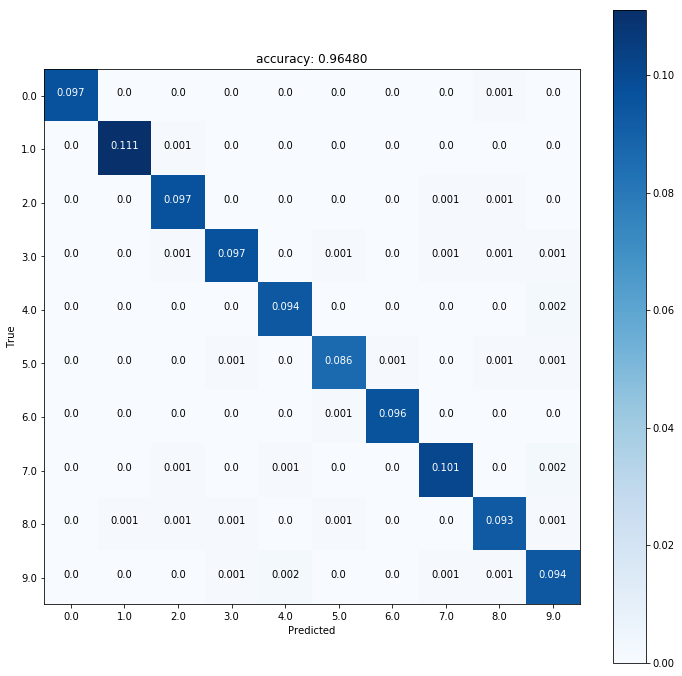

In [20]:
_ = simple_classification_performance(
    extended_images, 
    labels,
    model_name='random_forest',
    n_folds=3,
    grid={'max_depth': [20]},
    run_grid_search=False)

## How can we effectively use the information gained from convolutions?
Convolution Neural Networks. They have the ability to optimize the combination of convolution filters and use them to build more abstract features.

## Test model

In [21]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    digit_images, 
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42)

In [22]:
hyperparametrized_model.fit(train_features, train_labels)

test_predictions = hyperparametrized_model.predict(test_features)

[9. 8. 6. 3. 6. 0.]
[1. 4. 1. 0. 4. 0.]
[2. 9. 2. 6. 5. 6.]
[3. 0. 1. 5. 7. 8.]
[6. 9. 9. 4. 7. 7.]


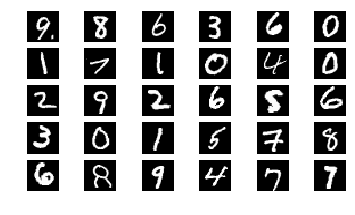

In [23]:
np.random.seed(42)
sample = np.random.randint(0, test_features.shape[0], size=30)

for i in range(5):
    print(test_predictions[sample][(6 * i):(6 * (i + 1))])

show_images(test_features[sample, :])

## See inside the model

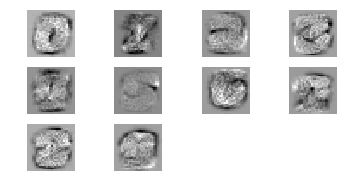

In [24]:
show_images(hyperparametrized_model.coef_)

## The business case

- We can partially automate form filling
- Need to focus on cases where the model has low confidence
- Time to use neural networks!